# Import dataset/libraries

In [1]:
import numpy as np # import numpy
import pandas as pd # import pandas
import matplotlib.pyplot as plt # matplotlib
import nltk
import re
from nltk import pos_tag # for part-of-speech tagging
from nltk.stem import PorterStemmer,LancasterStemmer
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import MinMaxScaler,LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold
from nltk.corpus import stopwords  #stopwords
from nltk import word_tokenize,sent_tokenize, pos_tag, pos_tag_sents
from wordcloud import WordCloud, STOPWORDS
from gensim.models import Word2Vec
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.feature_extraction.text import CountVectorizer

import warnings
warnings.filterwarnings(action = 'ignore')

In [2]:
nltk.download('stopwords')
stop = stopwords.words('english')

def tokenize(d):
    return word_tokenize(d)

def clean_text(d):
    pattern = r'[^a-zA-Z\s]'
    text = re.sub(pattern, '', d)
    return text

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Checked the head, info, and describe methods on created dataframe 'tweet'.

In [3]:
tweet = pd.read_csv("/kaggle/input/tweet-sentiments/test.csv")
train_df = pd.read_csv("/kaggle/input/tweet-sentiments/train.csv")

In [4]:
# Checking first 5 tweets

tweet.head()

,textID,text,sentiment
0,f87dea47db,Last session of the day http://twitpic.com/67ezh,neutral
1,96d74cb729,Shanghai is also really exciting (precisely -...,positive
2,eee518ae67,"Recession hit Veronique Branquinho, she has to...",negative
3,01082688c6,happy bday!,positive
4,33987a8ee5,http://twitpic.com/4w75p - I like it!!,positive


In [5]:
tweet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3534 entries, 0 to 3533
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   textID     3534 non-null   object
 1   text       3534 non-null   object
 2   sentiment  3534 non-null   object
dtypes: object(3)
memory usage: 83.0+ KB


In [6]:
tweet.describe()

,textID,text,sentiment
count,3534,3534,3534
unique,3534,3534,3
top,f87dea47db,Last session of the day http://twitpic.com/67ezh,neutral
freq,1,1,1430


Perform pre-processing steps like Removing Punctuations, Numbers, and Special Characters, Stop Words in dataset.

In [7]:
def basic_cleaning(text):
    """
    clear url/ not alpha/ fuck-bitch swear
    """
    text = re.sub(r'https?://www\.\S+\.cm', '', text)
    text = re.sub(r'[^a-zA-Z|\s]', '', text)
    text = re.sub(r'\*+', 'swear', text)
    return text

In [8]:
def remove_html(text):
    html = re.compile(r'<.*?>')
    return html.sub(r'',text)

In [9]:
def remove_emoji(text):
    #emoticons
    #symbols & pictographs
    #transport & map symbols
    #flags (iOS)
    emoji_pattern = re.compile("["\
        u"\U0001F600-\U0001F64F|"\
        u"\U0001F300-\U0001F5FF|"\
        u"\U0001F680-\U0001F6FF|"\
        u"\U0001F1E0-\U0001F1FF|"\
        u"\U00002702-\U000027B0|"\
        u"\U000024C2-\U0001F251"\
        "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

In [10]:
# remove repeated characters
def remove_multiplechars(text):
    """
    for example, so we have “way” instead of “waaaayyyyy”
    """
    text = re.sub(r'(.)\1{3,}', r'\1', text)
    return text


In [11]:
def clean(msg):
    for col in ['text']:#,'selected_text']:
        msg[col] = msg[col].astype(str).apply(lambda x:basic_cleaning(x))
        msg[col] = msg[col].astype(str).apply(lambda x:remove_emoji(x))
        msg[col] = msg[col].astype(str).apply(lambda x:remove_html(x))
        msg[col] = msg[col].astype(str).apply(lambda x:remove_multiplechars(x))
    return msg.sample(frac=1)

In [12]:
#cleaned_text
tweet_copy = tweet.copy()
cleaned_text = clean(tweet_copy)
cleaned_text_selection = cleaned_text.sample(frac=1)
X = cleaned_text_selection.text.values
y, uniques = pd.factorize(cleaned_text_selection.sentiment, sort=True)
y_tf = pd.get_dummies(cleaned_text_selection.sentiment)
print('clean Done')
tweet

clean Done


,textID,text,sentiment
0,f87dea47db,Last session of the day http://twitpic.com/67ezh,neutral
1,96d74cb729,Shanghai is also really exciting (precisely -...,positive
2,eee518ae67,"Recession hit Veronique Branquinho, she has to...",negative
3,01082688c6,happy bday!,positive
4,33987a8ee5,http://twitpic.com/4w75p - I like it!!,positive
...,...,...,...
3529,e5f0e6ef4b,"its at 3 am, im very tired but i can`t sleep ...",negative
3530,416863ce47,All alone in this old house again. Thanks for...,positive
3531,6332da480c,I know what you mean. My little dog is sinkin...,negative
3532,df1baec676,_sutra what is your next youtube video gonna b...,positive


<AxesSubplot:ylabel='sentiment'>

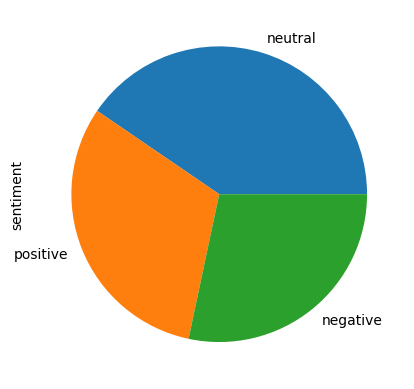

In [13]:
cleaned_text_selection.sentiment.value_counts().plot.pie()

Normalize review by using Stemming or Lemmatization

In [14]:
# Stemming
from nltk.stem.porter import PorterStemmer
stemmer = PorterStemmer()

def word_stemmer(text):
    stem_text = " ".join([stemmer.stem(i) for i in text])
    return stem_text

cleaned_text_selection['text'] = cleaned_text_selection['text'].apply(lambda x: word_stemmer(x))
cleaned_text.head(20)

,textID,text,sentiment
1715,0435d42f80,MAD AS HELL SOMEONE STOLE MY PINK BLACK LEAPO...,negative
501,2492330594,NOT excited for people reservation in the mor...,neutral
1716,1e633e1874,you didnt include Taylor in the Follow Friday,neutral
2177,c3541b6a2f,that sucks,negative
1836,d2a3207aae,Did you see Star Trek Now I cant sleeptoo muc...,neutral
702,41cf23c2d2,Bad migrane and need to go to dancing tonight ...,negative
812,47b4e91e39,rmbr the time when we torned for the night in ...,neutral
1378,8862c02132,Conference call with HP They gave me an inval...,negative
3358,daba837f14,I didnt even get a chance to shop Aldi,neutral
2205,cc0ad12b7c,my tix are in limboas usual UPSsucks,negative


Preprocessed text should be included in the tweet data frame as cleaned_text. Plot word cloud for all classes the tweets

In [15]:
tweet['cleaned_text'] = cleaned_text['text']
tweet.head(20)

,textID,text,sentiment,cleaned_text
0,f87dea47db,Last session of the day http://twitpic.com/67ezh,neutral,Last session of the day httptwitpiccomezh
1,96d74cb729,Shanghai is also really exciting (precisely -...,positive,Shanghai is also really exciting precisely s...
2,eee518ae67,"Recession hit Veronique Branquinho, she has to...",negative,Recession hit Veronique Branquinho she has to ...
3,01082688c6,happy bday!,positive,happy bday
4,33987a8ee5,http://twitpic.com/4w75p - I like it!!,positive,httptwitpiccomwp I like it
5,726e501993,that`s great!! weee!! visitors!,positive,thats great weee visitors
6,261932614e,I THINK EVERYONE HATES ME ON HERE lol,negative,I THINK EVERYONE HATES ME ON HERE lol
7,afa11da83f,"soooooo wish i could, but im in school and my...",negative,so wish i could but im in school and myspace ...
8,e64208b4ef,and within a short time of the last clue all ...,neutral,and within a short time of the last clue all ...
9,37bcad24ca,What did you get? My day is alright.. haven`...,neutral,What did you get My day is alright havent do...


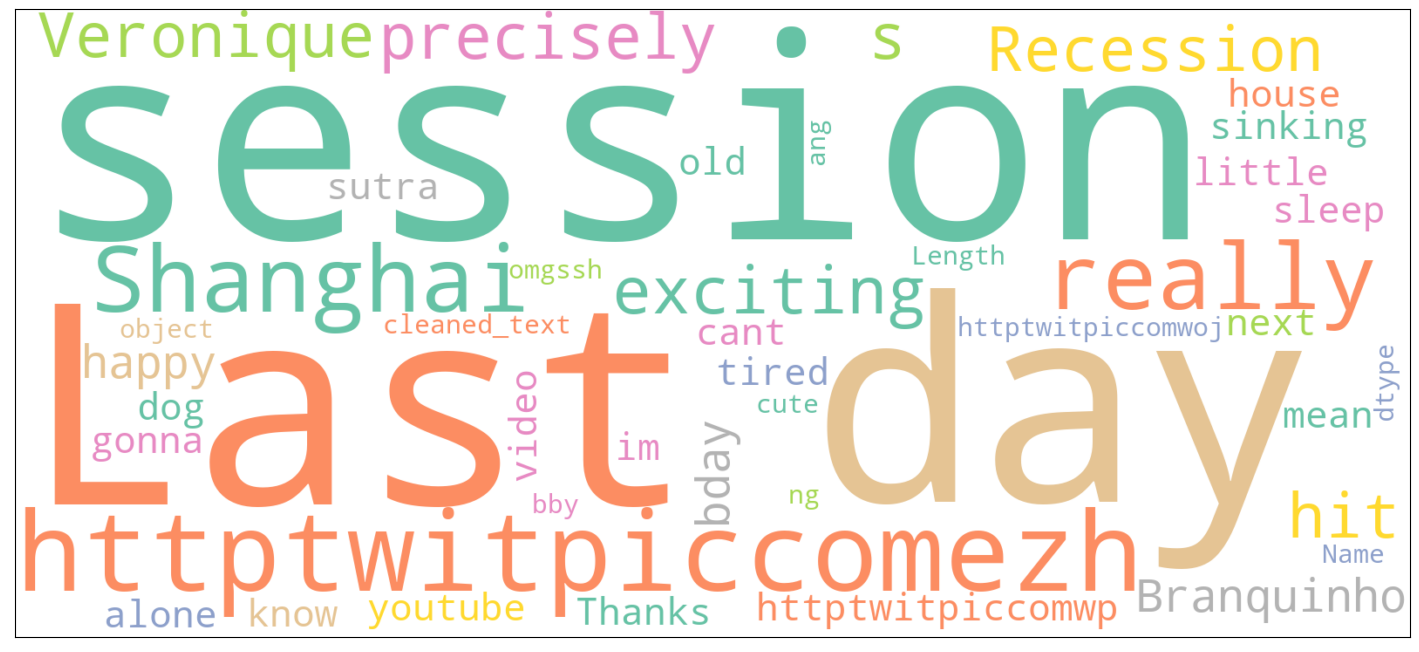

In [16]:
# Wordcloud for entire dataframe

plt.figure(figsize=(18,15))
wc = WordCloud(min_font_size=3,max_words=1000,width=1600,height=720,
                       colormap = 'Set2', background_color='white').generate(str(tweet['cleaned_text']))
plt.imshow(wc,interpolation='bilinear')
plt.xticks([])
plt.yticks([])
plt.grid(False)

In [17]:
# Wordcloud for each dataframe

positive = tweet[tweet.sentiment == 'positive'].text.apply(clean_text).apply(tokenize)
positive = [" ".join(positive.values[i]) for i in range(len(positive))]
positive = [" ".join(positive)][0]

negative = tweet[tweet.sentiment == 'negative'].text.apply(clean_text).apply(tokenize)
negative = [" ".join(negative.values[i]) for i in range(len(negative))]
negative = [" ".join(negative)][0]

neutral = tweet[tweet.sentiment == 'neutral'].text.apply(clean_text).apply(tokenize)
neutral = [" ".join(neutral.values[i]) for i in range(len(neutral))]
neutral = [" ".join(neutral)][0]

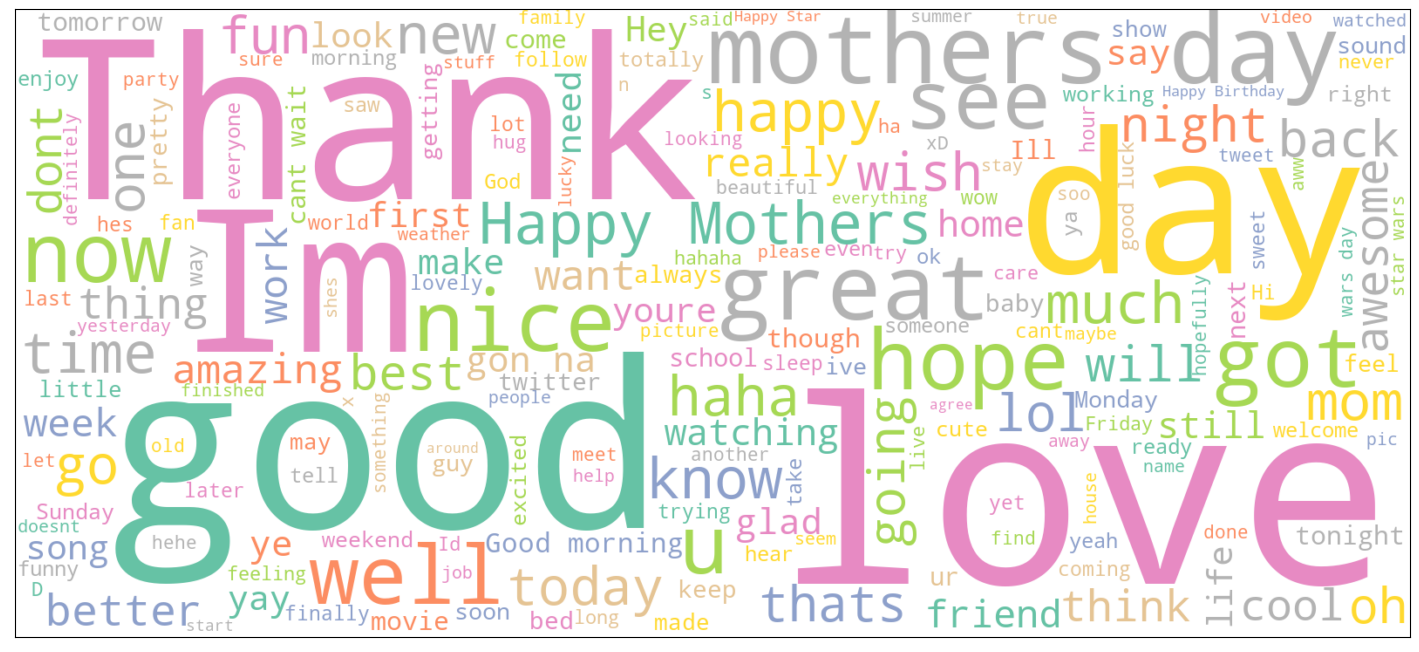

In [18]:
plt.figure(figsize=(18,15))
wc_positive = WordCloud(min_font_size=3,max_words=200,width=1600,height=720,
                       colormap = 'Set2', background_color='white').generate(positive)

plt.imshow(wc_positive,interpolation='bilinear')
plt.xticks([])
plt.yticks([])
plt.grid(False)

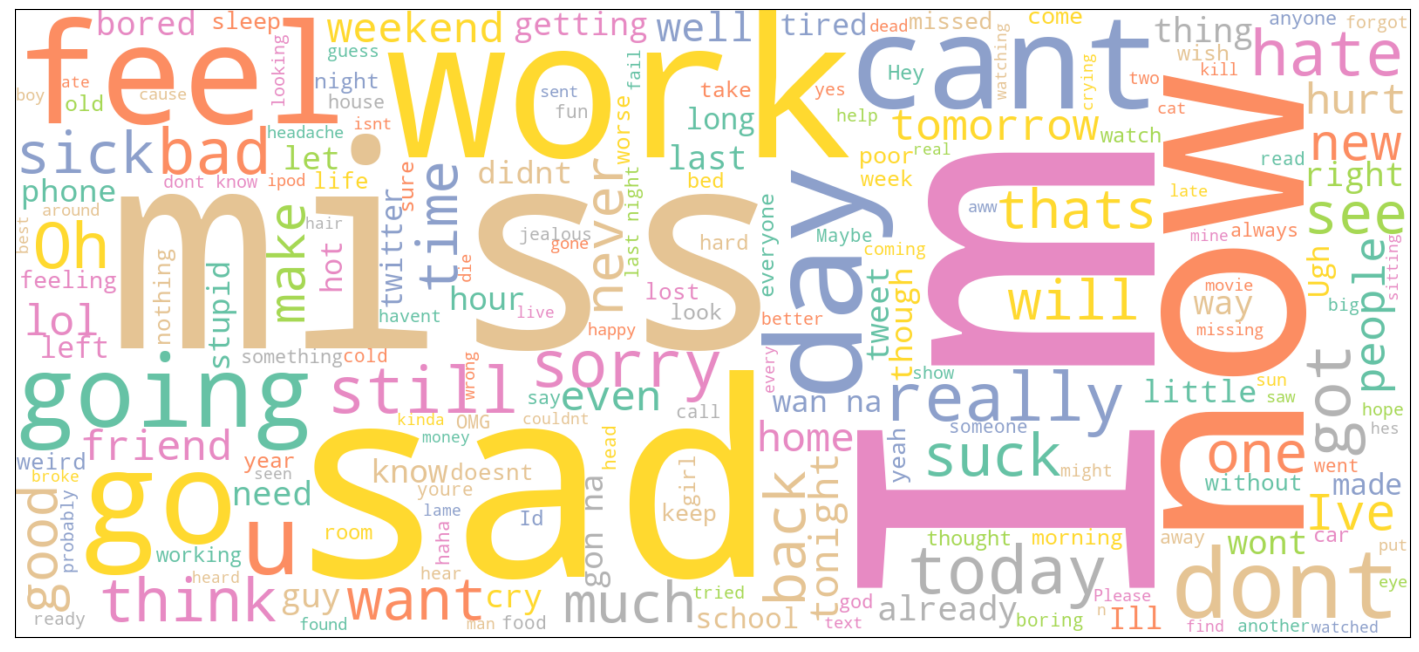

In [19]:
plt.figure(figsize=(18,15))
wc_negative = WordCloud(min_font_size=3,max_words=200,width=1600,height=720,
                       colormap = 'Set2', background_color='white').generate(negative)

plt.imshow(wc_negative,interpolation='bilinear')
plt.xticks([])
plt.yticks([])
plt.grid(False)

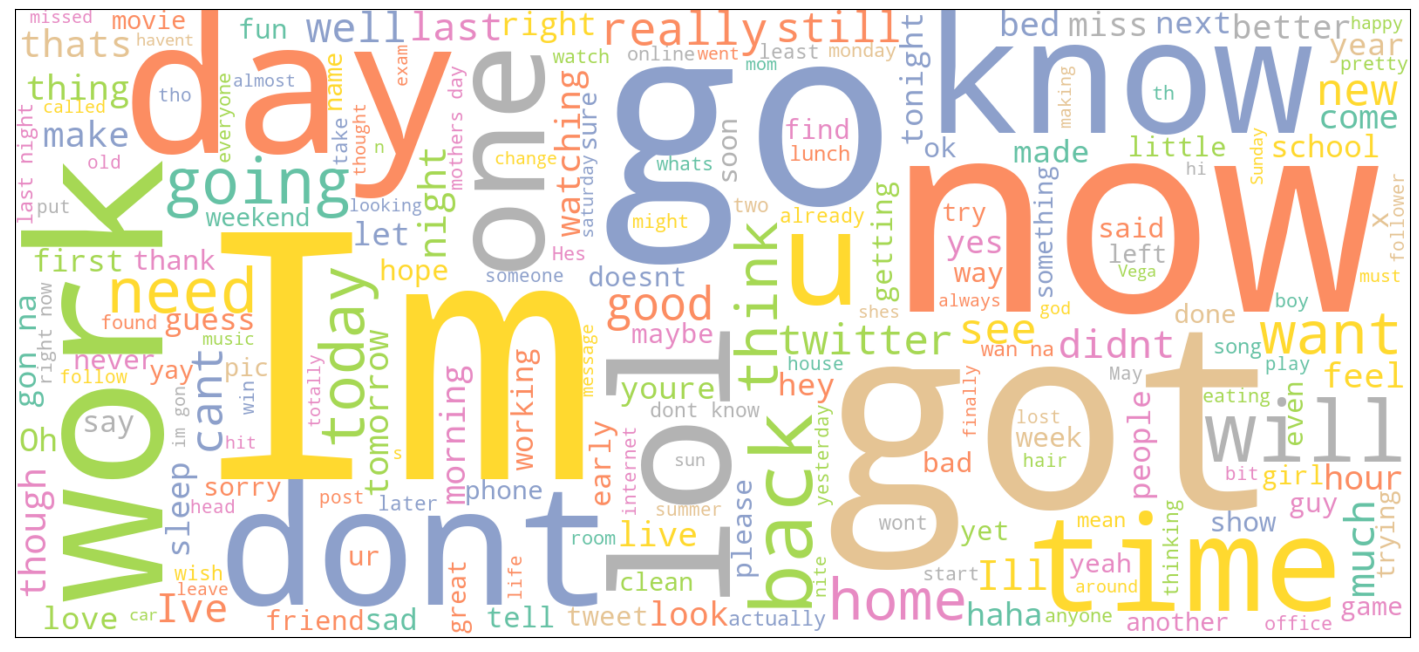

In [20]:
plt.figure(figsize=(18,15))
wc_neutral = WordCloud(min_font_size=3,max_words=200,width=1600,height=720,
                       colormap = 'Set2', background_color='white').generate(neutral)

plt.imshow(wc_neutral,interpolation='bilinear')
plt.xticks([])
plt.yticks([])
plt.grid(False)

In [21]:
def convert_Sentiment(sentiment):
    if  sentiment == "positive":
        return 2
    elif sentiment == "neutral":
        return 1
    elif sentiment == "negative":
        return 0
    
tweet['converted_sentiment'] = tweet.sentiment.apply(lambda x : convert_Sentiment(x))

Create two objects X and y. X will be the 'cleaned_text ' column of tweet data frame and y will be the ' Sentiment' column.

In [22]:
x = tweet['cleaned_text']
y = tweet['converted_sentiment']
x.sample(5)

1794    Just snuck out my window Now im laying on my r...
3425     yeah whateverin your twisted mind maybe  LOL ...
2142    I get the feeling  is going to make me wait un...
682                   People at work are stressing me out
1939     Which denomination Im at the library and ever...
Name: cleaned_text, dtype: object

In [23]:
y.sample(5)

1600    1
776     2
1069    0
833     1
718     1
Name: converted_sentiment, dtype: int64

Create a Word2Vec object and split the data into training and testing sets. Train a Decision tree model and Display the confusion Matrix.

In [24]:
tweet['tokenized_sents'] = tweet.apply(lambda row: nltk.word_tokenize(row['cleaned_text']), axis=1)
X = tweet.cleaned_text
y = tweet.converted_sentiment

X_trn, X_tst, y_trn, y_tst = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [25]:
# Setting sg = 1 for Word2Vec 
texts_w2v = tweet.tokenized_sents.to_list()
w2v = Word2Vec(sentences = texts_w2v, window = 3, vector_size = 100, min_count = 5, workers = 4, sg = 1)

In [26]:
def get_avg_vector(sent):
    vector = np.zeros(100)
    total_words = 0
    for word in sent.split():        
        if word in w2v.wv.key_to_index:    
            vector += w2v.wv.word_vec(word)
            total_words += 1
    if total_words > 0:
        return vector / total_words
    else:
        return vector
    
tweet['w2v_vector'] = tweet['cleaned_text'].map(get_avg_vector)
tweet[['cleaned_text', 'w2v_vector']].head(2)

,cleaned_text,w2v_vector
0,Last session of the day httptwitpiccomezh,"[-0.06167525611817837, 0.14596657268702984, 0...."
1,Shanghai is also really exciting precisely s...,"[-0.059617042541503906, 0.14395263152463095, 0..."


In [27]:
# Logistic regression and confusion matrix
model_params = {'random_state':42}
model_list = [LogisticRegression(**model_params, solver='liblinear')]
model_name = ['LogisticRegression']

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for model, model_name in zip(model_list, model_name):
    for n_fold, (trn_idx, vld_idx) in enumerate(skf.split(tweet.index, tweet.converted_sentiment)):        
        X_trn = np.stack(tweet.loc[trn_idx, 'w2v_vector'])
        y_trn = tweet.loc[trn_idx, 'converted_sentiment']
        
        X_vld = np.stack(tweet.loc[vld_idx, 'w2v_vector'])
        y_vld = tweet.loc[vld_idx, 'converted_sentiment']        
        
        model.fit(X_trn, y_trn)
        pred_col = f"{model_name}_w2v_pred"
        tweet.loc[vld_idx, pred_col] = model.predict(X_vld)
        modelTrain = model.predict(X_trn)
        modelTest = model.predict(X_vld)


# print(confusion_matrix(y_vld, modelTest))       

    

In [28]:
from sklearn.tree import DecisionTreeClassifier
classifier = DecisionTreeClassifier()

In [29]:
# DecisionTreeClassifier and confusion matrix
classifier = DecisionTreeClassifier()
classifier.fit(X_trn, y_trn)
y_pred = classifier.predict(X_vld)
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_vld, y_pred))
print(classification_report(y_vld, y_pred))

[[ 57  73  70]
 [ 75 136  75]
 [ 51  82  87]]
              precision    recall  f1-score   support

           0       0.31      0.28      0.30       200
           1       0.47      0.48      0.47       286
           2       0.38      0.40      0.38       220

    accuracy                           0.40       706
   macro avg       0.38      0.39      0.38       706
weighted avg       0.39      0.40      0.40       706



Create a CBow object and split the data into training and testing sets. Train a Logistic Regression and decision tree model. Display the confusion Matrix for both train and test.

In [30]:
# Setting sg = 0 for CBOW 
w2v = Word2Vec(sentences = texts_w2v, window = 3, vector_size = 100, min_count = 5, workers = 4, sg = 0)

In [31]:
# DecisionTreeClassifier and confusion matrix
classifier = DecisionTreeClassifier()
classifier.fit(X_trn, y_trn)
y_pred = classifier.predict(X_vld)
y_trainset = classifier.predict(X_trn)
from sklearn.metrics import classification_report, confusion_matrix

# Confusion matrix for test set
print(confusion_matrix(y_vld, y_pred))
print(classification_report(y_vld, y_pred))

[[ 68  69  63]
 [ 74 131  81]
 [ 47  95  78]]
              precision    recall  f1-score   support

           0       0.36      0.34      0.35       200
           1       0.44      0.46      0.45       286
           2       0.35      0.35      0.35       220

    accuracy                           0.39       706
   macro avg       0.39      0.38      0.38       706
weighted avg       0.39      0.39      0.39       706



In [32]:
# Confusion matrix for train set
print(confusion_matrix(y_trn, y_trainset))
print(classification_report(y_trn, y_trainset))

[[ 795    6    0]
 [   2 1142    0]
 [   0   10  873]]
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       801
           1       0.99      1.00      0.99      1144
           2       1.00      0.99      0.99       883

    accuracy                           0.99      2828
   macro avg       0.99      0.99      0.99      2828
weighted avg       0.99      0.99      0.99      2828



In [33]:
# Logistic regression and confusion matrix
model_params = {'random_state':42}
model_list = [LogisticRegression(**model_params, solver='liblinear')]
model_name = ['LogisticRegression']

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for model, model_name in zip(model_list, model_name):
    for n_fold, (trn_idx, vld_idx) in enumerate(skf.split(tweet.index, tweet.converted_sentiment)):        
        X_trn = np.stack(tweet.loc[trn_idx, 'w2v_vector'])
        y_trn = tweet.loc[trn_idx, 'converted_sentiment']
        
        X_vld = np.stack(tweet.loc[vld_idx, 'w2v_vector'])
        y_vld = tweet.loc[vld_idx, 'converted_sentiment']        
        
        model.fit(X_trn, y_trn)
        pred_col = f"{model_name}_w2v_pred"
        tweet.loc[vld_idx, pred_col] = model.predict(X_vld)
        modelTrain = model.predict(X_trn)
        modelTest = model.predict(X_vld)

# Confusion matrix for test set
print(confusion_matrix(y_vld, modelTest))  

# Confusion matrix for test set
print(confusion_matrix(y_trn, modelTrain))  

[[  0 200   0]
 [  0 286   0]
 [  0 220   0]]
[[   0  801    0]
 [   0 1144    0]
 [   0  883    0]]


Display the HMM POS tagging on the first 4 rows of ‘cleaned_text’.

In [34]:
# Selected first 4 rows of tweet dataframe
selected_tweet = tweet.head(4)
texts = selected_tweet['cleaned_text'].tolist()
texts

['Last session of the day  httptwitpiccomezh',
 ' Shanghai is also really exciting precisely  skyscrapers galore Good tweeps in China  SH  BJ',
 'Recession hit Veronique Branquinho she has to quit her company such a shame',
 ' happy bday']

In [35]:
# POS tagging
nltk.download('averaged_perceptron_tagger')
tagged_texts = pos_tag_sents(map(word_tokenize, texts))
tagged_texts

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


[[('Last', 'JJ'),
  ('session', 'NN'),
  ('of', 'IN'),
  ('the', 'DT'),
  ('day', 'NN'),
  ('httptwitpiccomezh', 'VB')],
 [('Shanghai', 'NNP'),
  ('is', 'VBZ'),
  ('also', 'RB'),
  ('really', 'RB'),
  ('exciting', 'VBG'),
  ('precisely', 'RB'),
  ('skyscrapers', 'NNS'),
  ('galore', 'RB'),
  ('Good', 'JJ'),
  ('tweeps', 'NNS'),
  ('in', 'IN'),
  ('China', 'NNP'),
  ('SH', 'NNP'),
  ('BJ', 'NNP')],
 [('Recession', 'NN'),
  ('hit', 'VBD'),
  ('Veronique', 'NNP'),
  ('Branquinho', 'NNP'),
  ('she', 'PRP'),
  ('has', 'VBZ'),
  ('to', 'TO'),
  ('quit', 'VB'),
  ('her', 'PRP$'),
  ('company', 'NN'),
  ('such', 'PDT'),
  ('a', 'DT'),
  ('shame', 'NN')],
 [('happy', 'JJ'), ('bday', 'NN')]]